#### **1) Libraries**

In [ ]:
# !pip install -U tensorflow_probability -q
!pip install -q ipdb

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose 

If using Google Colab, save in your Google Drive.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) MNIST Data**

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
def preprocess_images(images, image_size, batch_size, nn_type):
    if nn_type == 'conv':
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    else:
        images = images.reshape((images.shape[0], -1)) / 255.
    images = np.where(images > .5, 1.0, 0.0).astype('float32')
    return (tf.data.Dataset.from_tensor_slices(images)
            .shuffle(image_size).batch(batch_size))

In [ ]:
train_size = 60000
test_size = 10000
batch_size = 32  # Also use this batch_size for Model Train 

In [ ]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
# Use CNN
train_dataset = preprocess_images(train_images, train_size, batch_size, 'conv')
test_dataset = preprocess_images(test_images, test_size, batch_size, 'conv')
# Use Dense
# train_dataset = preprocess_images(train_images, train_size, batch_size, 'dense')
# test_dataset = preprocess_images(test_images, test_size, batch_size, 'dense')

In [ ]:
print(train_dataset), print(test_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


(None, None)

#### **3) Model Class**

In [ ]:
class Sampler_Z(keras.layers.Layer):

    def call(self, inputs):
        mu, rho = inputs
        sd = tf.math.log(1+tf.math.exp(rho))
        batch_size = tf.shape(mu)[0]
        dim_z = tf.shape(mu)[1]
        z_sample = mu + sd * tf.random.normal(shape=(batch_size, dim_z))
        return z_sample, sd

In [ ]:
class Encoder_Z(keras.layers.Layer):

    def __init__(self, dim_z, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.conv_layer_1 = Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                   padding='valid', activation='relu'
                                   )
        self.conv_layer_2 = Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                    padding='valid', activation='relu'
                                    )
        self.flatten_layer = Flatten()
        # No activation
        self.dense_mean = Dense(self.dim_z, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(self.dim_z, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.conv_layer_2(z)
        z = self.flatten_layer(z)
        mu = self.dense_mean(z)
        rho = self.dense_raw_stddev(z)
        z_sample, sd = self.sampler_z((mu,rho))
        return z_sample, mu, sd

In [ ]:
class Decoder_X(keras.layers.Layer):

    def __init__(self, dim_z, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.dim_z = dim_z
        self.dense_z_input = Dense(7*7*32, activation=None)
        self.reshape_layer = Reshape((7,7,32))
        self.conv_transpose_layer_1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                                      padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                                      padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_3 = Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                                      padding='same'
                                                      )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        return x_output

In [ ]:
class VAEModel(keras.Model):
    """Variational Autoencoder base model."""

    def __init__(self, dim_z, learning_rate=0.0005, kl_weight=1, name="autoencoder", **kwargs):
        super(VAEModel, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.encoder = Encoder_Z(dim_z)
        self.decoder = Decoder_X(dim_z)
        self.kl_weight = kl_weight

    # def encode_and_decode(self, x_input):
    def call(self, x_input):
        z_sample, mu, sd = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        
        kl_divergence = - 0.5 * tf.math.reduce_sum(1 + \
                                                   tf.math.log(tf.math.square(sd)) - \
                                                   tf.math.square(mu) - \
                                                   tf.math.square(sd), axis=1
                                                   )
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        # self.add_loss(lambda: self.kl_weight * kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        return x_recons_logits

    '''
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decoder(eps, apply_sigmoid=True)
    '''

In [ ]:
class VAE:
    """Variational Autoencoder wrapper."""
    # def __init__(self, n_hidden, latent_dim, dropout=0.):
    def __init__(self, latent_dim):
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        # self.optimizer = keras.optimizers.Adam(learning_rate)
        self.loss_metric = keras.metrics.Mean()
        self.model = VAEModel(latent_dim)
        # self.model = VAEModel(n_hidden, latent_dim, dropout)

    def train(self, train_dataset, test_dataset, epochs=100, batch_size=0, show_display=True):
        # Pick a sample of the test set for generating output images
        num_examples_to_generate = 16
        assert batch_size >= num_examples_to_generate
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:num_examples_to_generate, :, :, :]

        for epoch in range(1, epochs + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()

            loss = tf.keras.metrics.Mean()
            for test_x in test_dataset:
                loss(self.partial_vae_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                    .format(epoch, elbo, end_time - start_time))
            if show_display:
                # self.generate_and_save_images(epoch, test_sample)
                self.generate_images(test_sample, epoch)

    @tf.function
    def train_step(self, x):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        # ipdb.set_trace()
        with tf.GradientTape() as tape:
            neg_log_lik = self.partial_vae_loss(x)
            # kl_loss = model.losses[-1]
            kl_loss = tf.math.reduce_sum(self.model.losses)  # vae.losses is a list
            total_vae_loss = neg_log_lik + kl_loss
        gradients = tape.gradient(total_vae_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_metric(total_vae_loss)
        '''
        with tf.GradientTape() as tape:
            loss = self._compute_loss(x)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        '''

    # vae loss function -- only the negative log-likelihood part, 
    # since we use add_loss for the KL divergence part
    def partial_vae_loss(self, x_true):
        # x_recons_logits = model.encode_and_decode(x_true)
        x_recons_logits = self.model(x_true)
        # compute cross entropy loss for each dimension of every datapoint
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
        return tf.math.reduce_mean(neg_log_likelihood)

    def generate_images(self, test_images, epoch, sample=False, n_samples=16, latent_dim=2):
        if sample:
            z_sample = tf.random.normal(shape=(n_samples, latent_dim))
            x_recons_logits = self.model.decoder(z_sample)
        else: 
            x_recons_logits = self.model(test_images)
        doecder_samples = tf.math.sigmoid(x_recons_logits)
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(doecder_samples.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(doecder_samples[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig(f'image_at_epoch_{epoch:04d}.png')
        plt.show()

    '''
    def _compute_loss(self, x):
        mean, logvar = self.model.encode(x)
        z = self.model.reparameterize(mean, logvar)
        x_logit = self.model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self._log_normal_pdf(z, 0., 0.)
        logqz_x = self._log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        predictions = self.model.decoder(z_sample)
        # mean, logvar = self.model.encode(test_sample)
        # z = self.model.reparameterize(mean, logvar)
        # predictions = self.model.sample(z_sample)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
    '''

#### **4) Models Train**

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 4  # 2
batch_size = 32
num_examples_to_generate = 16

In [ ]:
vae = VAE(latent_dim)

Epoch: 10, Test set ELBO: -120.7957534790039, time elapse for current epoch: 6.578831195831299


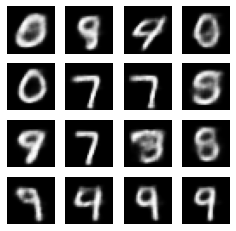

In [ ]:
vae.train(train_dataset, test_dataset, epochs, batch_size)